In this post, we will use a little geography to determine the topology of Paris as seen from the point of view of my alarm clock. Here's the context: I'd like to move flats in the Paris area and take advantage of the transportation means set up by my company. My company provides a number of bus routes travelling to our offices every morning, with each bus route consisting of a number of stops at given times.

Using some data that I collected on my company's internal website and coordinates from Google Maps, the goal of this post can be described as: 

"which location within Paris would allow me to get out of the house the latest and still get to work on time?"

Let's see if how we can answer this question.

# The data 

Firsts, we load the data for the bus departure times. We will encode the departure time as the minutes elapsed since midnight.

In [2]:
departure_times = list(map(lambda s: (int(s.split('\t')[0]) * 60 + int(s.split('\t')[1])),
    """7	30
7	35
7	36
7	40
7	45
7	15
7	27
7	25
7	29
7	27
7	45
7	45
7	40
7	30
7	35
7	33
7	30
7	27
7	20
7	13""".split('\n')))

We now define the location coordinates for each bus in `(latitude, longitude)` format.

In [4]:
location_coords = list(map(lambda s: (float(s.split(',')[0]), float(s.split(',')[1])),
"""48.878428, 2.282963
48.870967, 2.275274
48.863403, 2.268703
48.846252, 2.257876
48.837814, 2.256867
48.837877, 2.274259
48.836091, 2.277381
48.832199, 2.287949
48.826994, 2.300598
48.827143, 2.304493
48.819960, 2.324732
48.815806, 2.344237
48.819381, 2.359011
48.830428, 2.352359
48.831459, 2.398214
48.835386, 2.406239
48.846754, 2.411582
48.853348, 2.410273
48.863569, 2.408535
48.876956, 2.406550""".split('\n')))

# Visualizing the data 

With the data points having been defined, we can now visualize tan approximate map of the bus departure times using the latitudes and longitudes of the bus stops as X,Y coordinates.

In [1]:
from pylab import *
%matplotlib inline

(48.81, 48.89)

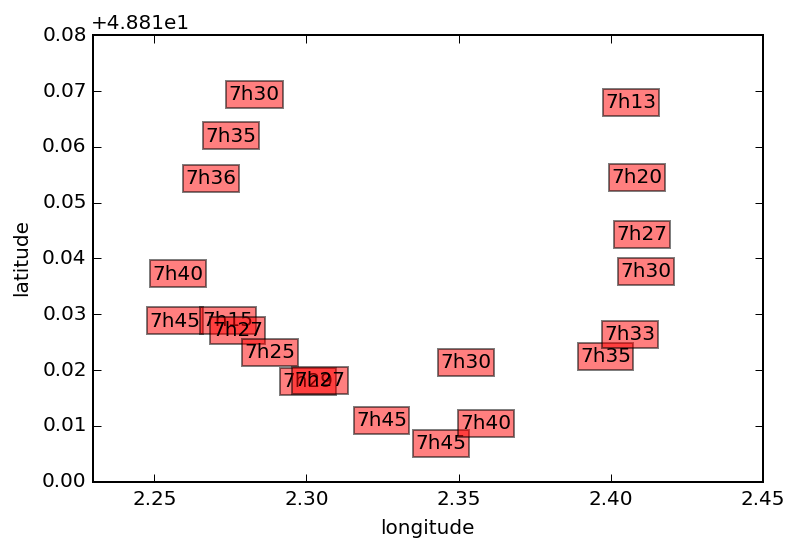

In [43]:
format_hour = lambda hour: "{0}h{1}".format(hour // 60, hour % 60)

for hour, (lat, lng) in zip(departure_times, location_coords):
    text(lng, lat, format_hour(hour), bbox=dict(facecolor='red', alpha=0.5), horizontalalignment='center')
xlabel("longitude")
ylabel("latitude")
xlim(2.23, 2.45)
ylim(48.81, 48.89)

This being done, we can now start doing some computations!

# Computing the nearest distance to a bus stop

As we're going to do some computation on a map, let's define a mesh we can use to compute stuff:

In [6]:
lat_min = min([c[0] for c in location_coords])

In [7]:
lat_max = max([c[0] for c in location_coords])

In [8]:
long_min = min([c[1] for c in location_coords])

In [9]:
long_max = max([c[1] for c in location_coords])

Our bus stops are located within the following coordinates:

In [10]:
print(lat_min, lat_max, long_min, long_max)

48.815806 48.878428 2.256867 2.411582


However, to compute stuff, we'll use a grid that's a little bit larger than just the coordinates of the bus stops:

In [44]:
x = linspace(long_min - 0.05, long_max + 0.05, 250)
y = linspace(lat_min - .03, lat_max + 0.03, 200)

In [45]:
X, Y = meshgrid(x, y)

The next thing we will need is a function able to compute a distance between two points defined by their respective latitudes and longitudes. The math for this is a little complex but we're lucky: someone already wrote an implementation in Python, which we're going to use. Thanks John D. Cook: [http://www.johndcook.com/blog/python_longitude_latitude/](http://www.johndcook.com/blog/python_longitude_latitude/)!

In [46]:
import math
 
def distance_on_unit_sphere(lat1, long1, lat2, long2):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return 6371 * arc # distance will be in km

Our first question is: how far is each point in our mesh from the nearest bus stop? It turns out this is quite easy to compute, using a little loop.

In [47]:
distance_to_bus = nan * zeros_like(X)

for i in range(x.size):
    for j in range(y.size):
        for k in range(len(location_coords)):
            dist_to_loc = distance_on_unit_sphere(Y[j,i], X[j, i], 
                                                location_coords[k][0], location_coords[k][1])
            if isnan(distance_to_bus[j, i]):
                distance_to_bus[j, i] = dist_to_loc
            else:
                distance_to_bus[j, i] = min(distance_to_bus[j, i], dist_to_loc)

We can plot the computed distance to the nearest bus stops as an approximate map using latitude and longitude:

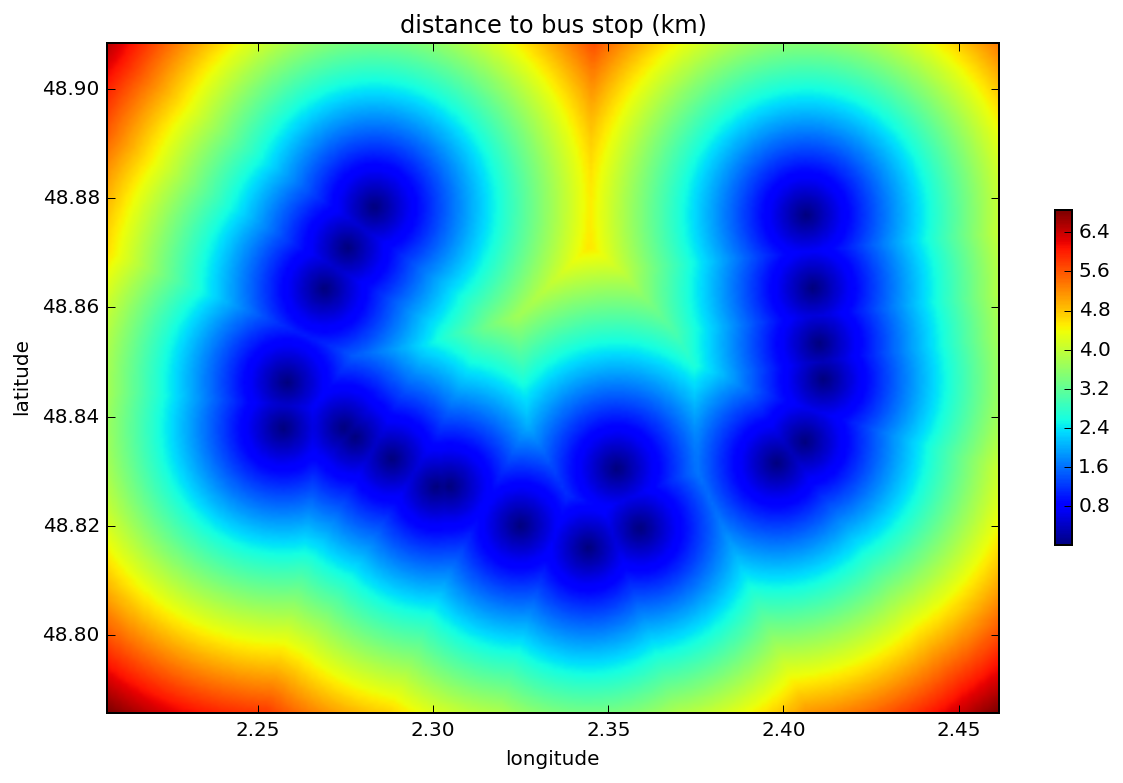

In [51]:
figure(figsize=(10, 6))
imshow(distance_to_bus, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), aspect='auto')
colorbar(shrink=0.5)
title('distance to bus stop (km)')
xlabel("longitude")
ylabel("latitude")

This is a nice visualization, but we can do much better if we use the appropriate toolkit! The `basemap` package that works with `matplotlib` is exactly what we are looking for.

In [52]:
from mpl_toolkits.basemap import Basemap

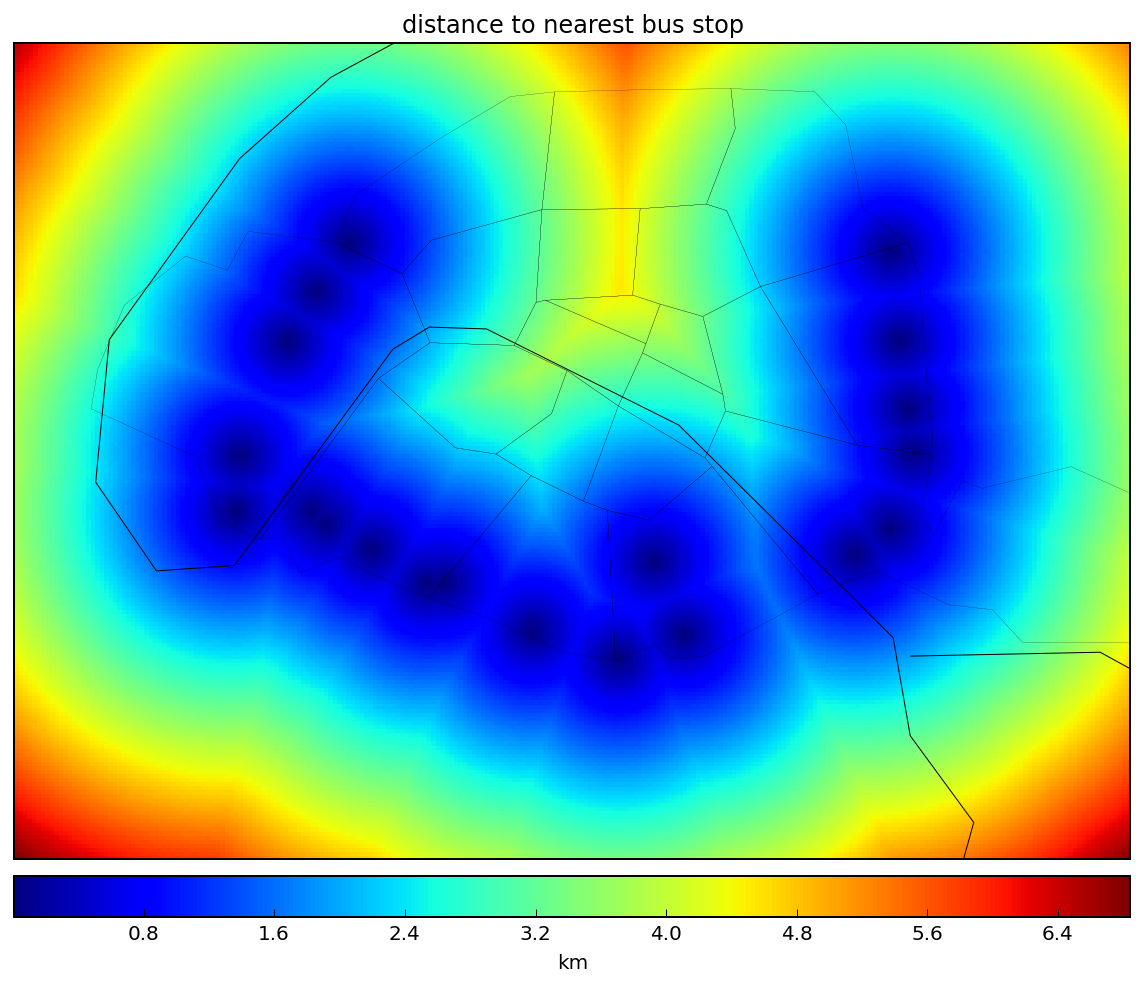

In [55]:
from matplotlib.collections import LineCollection
import shapefile

figure(figsize=(10, 10))
ax = subplot(111)

# first, choose map coordinates and draw rivers
m = Basemap(projection='stere',
            resolution='h',
            llcrnrlon=x.min(),
           llcrnrlat=y.min(),
           urcrnrlon=x.max(),
           urcrnrlat=y.max(),
           lon_0=x.mean(),
           lat_0=y.mean())
m.drawrivers() # the Seine

# secondly, add departments from detailed shapefile (fra_adm5)
r = shapefile.Reader(r"files/france_shapes/fra_adm5")
shapes = r.shapes()
records = r.records()
for record, shape in zip(records,shapes):
    if record[6] == 75: # filtering Paris data
        lons,lats = zip(*shape.points)
        data = np.array(m(lons, lats)).T
     
        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])
     
        lines = LineCollection(segs,antialiaseds=(1,))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        ax.add_collection(lines)
        
im1 = m.pcolormesh(X,Y,distance_to_bus,shading='flat',cmap=plt.cm.jet,latlon=True)
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('km')
ax.set_title('distance to nearest bus stop')

# Computing the time at which I need to leave to get to the bus on time 

The distances to the nearest bus stop, which we have plotted in the previous image, are nice, but they don't take into account the time at which the bus leaves. To take this information into account in the plot, we can compute the time at which we need to leave a point on the mesh to reach the nearest bus on time. 

We do this by using the following formula:

$$
t_{\text{leave_appartment}}(x, y) = t_{\text{nearest_bus_leaves}} - \text{distance_to_bus} * \text{walking_speed}
$$

In [57]:
walking_speed = 10. # minutes per kilometer

In [58]:
start_time = nan * zeros_like(X)

for i in range(x.size):
    for j in range(y.size):
        for k in range(len(location_coords)):
            dist_to_loc = distance_on_unit_sphere(Y[j,i], X[j, i], 
                                                location_coords[k][0], location_coords[k][1])
            time_to_leave = departure_times[k] - dist_to_loc * walking_speed
            if isnan(start_time[j, i]):
                start_time[j, i] = time_to_leave
            else:
                start_time[j, i] = max(start_time[j, i], time_to_leave)

We can plot the resulting departure times, just like for the distances:

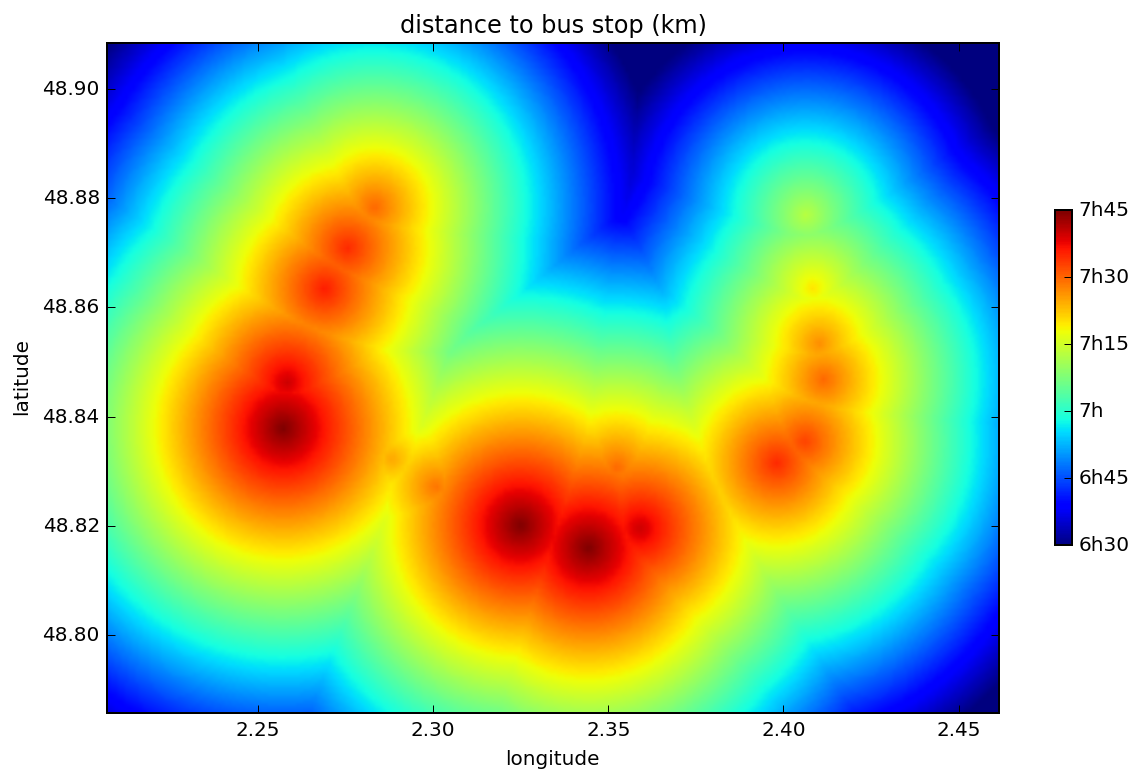

In [65]:
labels = array([6.5, 6.75, 7, 7.25, 7.5, 7.75]) * 60
ticklabels = ['6h30', '6h45', '7h', '7h15', '7h30', '7h45']

figure(figsize=(10, 6))
imshow(start_time, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), aspect='auto',
      vmin=labels.min(), vmax=labels.max())
cbar = colorbar(shrink=0.5)
cbar.set_ticks(labels)
cbar.set_ticklabels(ticklabels)
title('distance to bus stop (km)')
xlabel("longitude")
ylabel("latitude")

And finally, we can plot this on a real geographic map, superimposing the Paris contours on top.

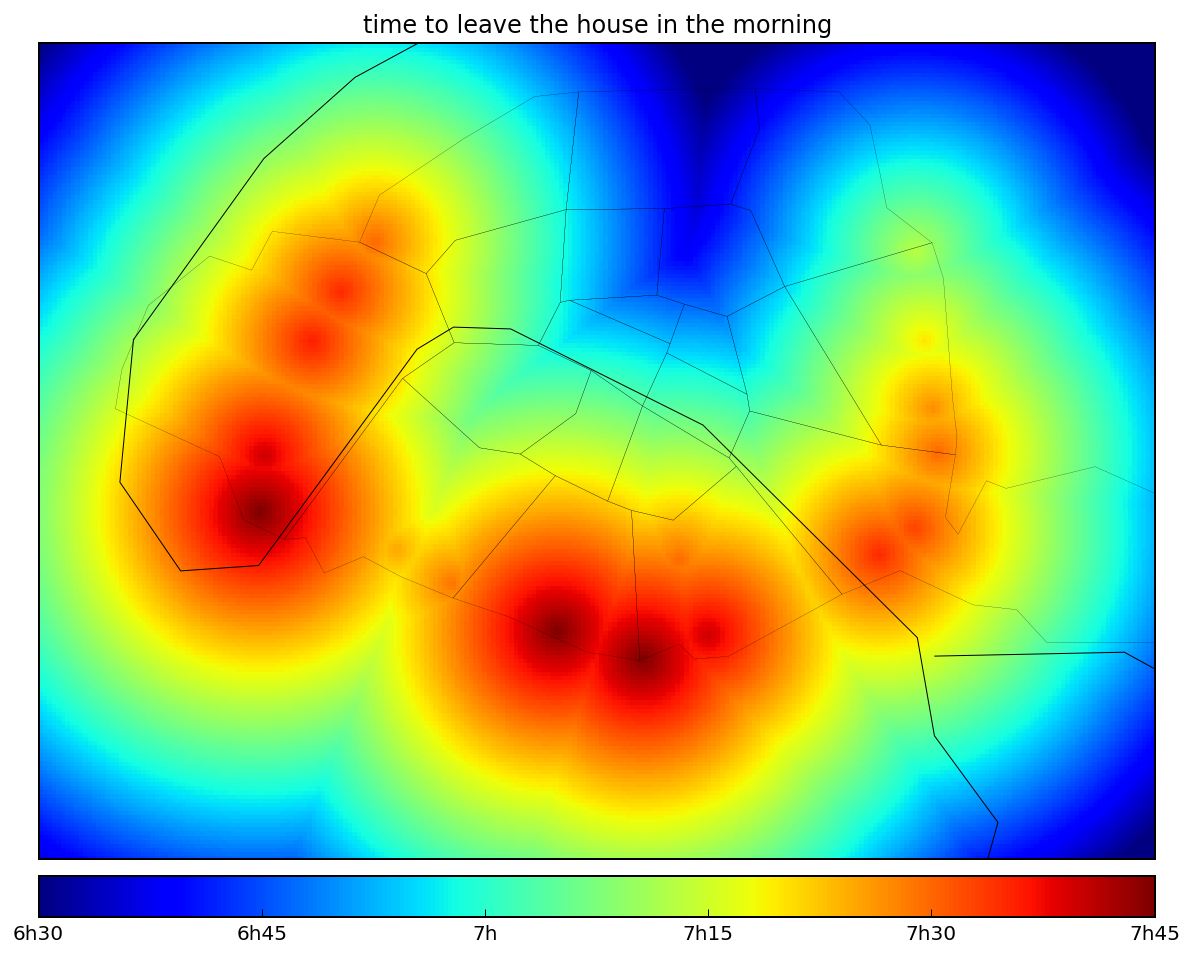

In [66]:
from matplotlib.collections import LineCollection
import shapefile

figure(figsize=(10, 10))
ax = subplot(111)

# first, choose map coordinates and draw rivers
m = Basemap(projection='stere',
            resolution='h',
            llcrnrlon=x.min(),
           llcrnrlat=y.min(),
           urcrnrlon=x.max(),
           urcrnrlat=y.max(),
           lon_0=x.mean(),
           lat_0=y.mean())
m.drawrivers() # the Seine

# secondly, add departments from detailed shapefile (fra_adm5)
r = shapefile.Reader(r"files/france_shapes/fra_adm5")
shapes = r.shapes()
records = r.records()
for record, shape in zip(records,shapes):
    if record[6] == 75: # filtering Paris data
        lons,lats = zip(*shape.points)
        data = np.array(m(lons, lats)).T
     
        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])
     
        lines = LineCollection(segs,antialiaseds=(1,))
        lines.set_edgecolors('k')
        lines.set_linewidth(0.1)
        ax.add_collection(lines)
        
im1 = m.pcolormesh(X, Y, start_time, shading='flat', cmap=plt.cm.jet, latlon=True, vmin=labels.min(), vmax=labels.max())
cbar = m.colorbar(im1,"bottom", size="5%", pad="2%")
cbar.set_ticks(labels)
cbar.set_ticklabels(ticklabels)
ax.set_title('time to leave the house in the morning')

As you can see in the map above, there clearly are some locations that are interesting as they allow me to sleep longer in the morning and some others that are way too far from the bus. One can note that for really long distances, this map is not accurate anymore as it makes the assumption that I'm walking to the bus. This would obviously not be true if I had to get out of the house at 6h45: in that case, I'd probably take a metro or a Vélib to get to the bus stop. So actually, this is not the real topology of the house leaving time, but it gives an approximate sense for the places nearest to the bus stops.

# Conclusion

Time to wrap this post up. I hope you've enjoyed how easy it is to work with geographic coordinates using `matplotlib` and `basemap`. I tried to use the bus travel times and bus stop locations to make a map that would be useful in the process of looking for a new appartment. The map making process could actually be extended if it were possible to use Google Maps information as an input when computing the travel times. 

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20150404_BusDepartures.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20150404_BusDepartures.ipynb).